# 7. Image Segmentation Example

In this last notebook, we see a medical imaging example for which we can make use of neural networks. To this end, we consider the [LIDC-IDRI](https://pubmed.ncbi.nlm.nih.gov/21452728/) dataset of lung CT scans where anomalities, in particular lesions, were manually outlined by experts. The goal is to design a **neural network for image segmentation** 
which learns from previous outlines of lesions to predict anomalities in new lung CT scans.

Keywords: ```Semantic segmentation```, ```U-Net```, ```keras.layers.SeparableConv2D```, ```keras.layers.BatchNormalization```, ```keras.layers.UpSampling2D```

***

## U-Net-based Semantic Segmentation

**Semantic segmentation** describes the task of grouping pixels together which (semanticly) belong to one object. In that regrad, a particularly useful architecture for biomedical imaging tasks is the [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) illustrated in the following figure. It is a **fully-convolutional neural network** and can be used also with comparably small datasets.

<br><center><img src="images/U-Net.png" alt="U-Net" width="500"/></center></br>

The architecture we use in this notebook is based on the U-Net. We adopt the *U-Net Xception-style model* proposed in a [Keras tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/) on image segmentation.

With the following cell, we load and plot the dataset. Note that we only use a small subset (119 images) of the full dataset.

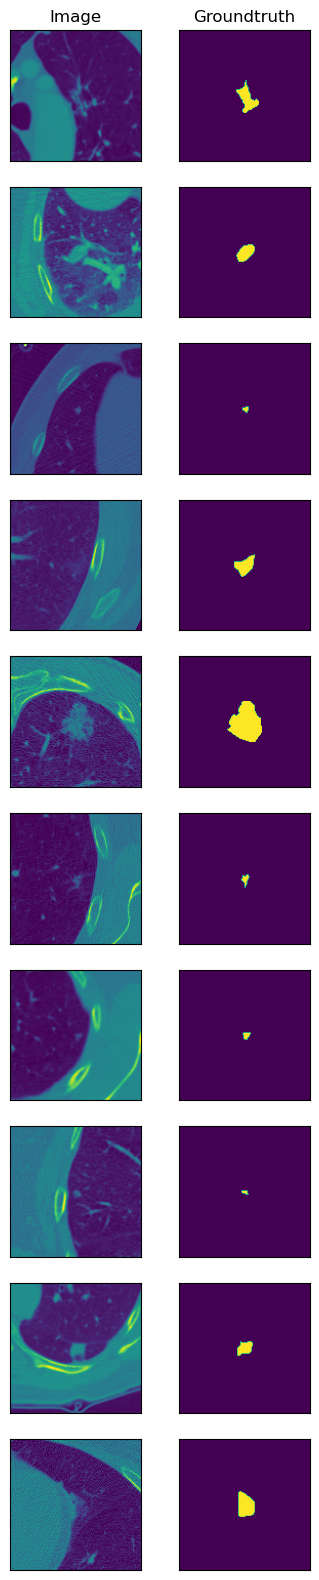

In [1]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load('data/lidc_images_119.npy')
targets = np.load('data/lidc_labels_119.npy')

fig, axs = plt.subplots(10,2, figsize=(4,20))

for i in range(10):
    axs[i,0].imshow(images[i])
    axs[i,1].imshow(targets[i])
    
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    
axs[0,0].set_title('Image')
axs[0,1].set_title('Groundtruth')
    
plt.show()

train_images = images[:100][...,np.newaxis]
train_targets = targets[:100][...,np.newaxis]

test_images = images[100:][...,np.newaxis]
test_targets = targets[100:][...,np.newaxis]

We use the following hyperparameters

In [2]:
learning_rate = 0.001
batch_size = 10
num_epochs = 10

and define the model as follows.

In [3]:
from tensorflow import keras

keras.utils.set_random_seed(123)

def segmentation_model(img_size=(128, 128), num_classes=2):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

2023-03-24 11:17:32.055524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now, we build the model.

In [4]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = segmentation_model(img_size=(128, 128), num_classes=2)
model.summary()

2023-03-24 11:24:35.665252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

With all of this in place, we can train our model. Note that
**this can take a substantial time**, depending on your machine and
the total amount of epochs.

Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 0.4991 - accuracy: 0.8788 - val_loss: 0.5404 - val_accuracy: 0.9819
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 0.1390 - accuracy: 0.9746 - val_loss: 0.4276 - val_accuracy: 0.9843
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 0.1257 - accuracy: 0.9796 - val_loss: 0.3386 - val_accuracy: 0.9845
Epoch 4/10
10/10 [==============================] - 16s 2s/step - loss: 0.1107 - accuracy: 0.9830 - val_loss: 0.2732 - val_accuracy: 0.9843
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 0.1066 - accuracy: 0.9836 - val_loss: 0.2272 - val_accuracy: 0.9840
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.0975 - accuracy: 0.9838 - val_loss: 0.1915 - val_accuracy: 0.9838
Epoch 7/10
10/10 [==============================] - 14s 1s/step - loss: 0.0956 - accuracy: 0.9849 - val_loss: 0.1633 - val_accuracy: 0.9839
Epoch 8/10
10/10 [==

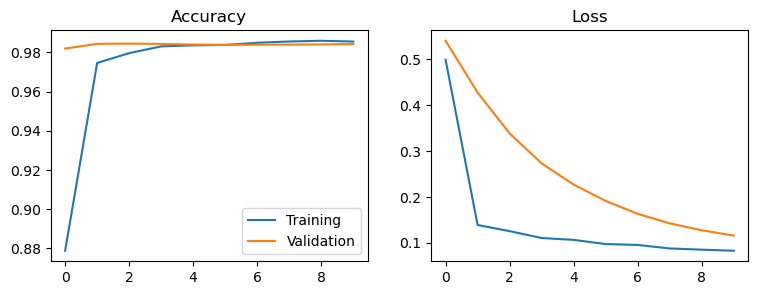

In [5]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_history = model.fit(x=train_images, y=train_targets, batch_size=batch_size, 
                          validation_data = (test_images, test_targets),
                          epochs=num_epochs)

fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(train_history.history['accuracy'], label='Training')
axs[0].plot(train_history.history['val_accuracy'], label='Validation')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(train_history.history['loss'])
axs[1].plot(train_history.history['val_loss'])
axs[1].set_title('Loss')

plt.show()

Save the trained model:

In [6]:
model.save_weights('output/Segmentation_model.h5', save_format='h5')

We provide again a pretrained model (500 epochs):

In [10]:
model.load_weights('output/Segmentation_model_pretrained.h5')

Make model prediction for both the training and test images.

In [11]:
train_prediction = model.predict(train_images)
test_prediction = model.predict(test_images)

1/1 [==============================] - 1s 859ms/step


First, we examine how well the model predicts the segmentation result on the training set.

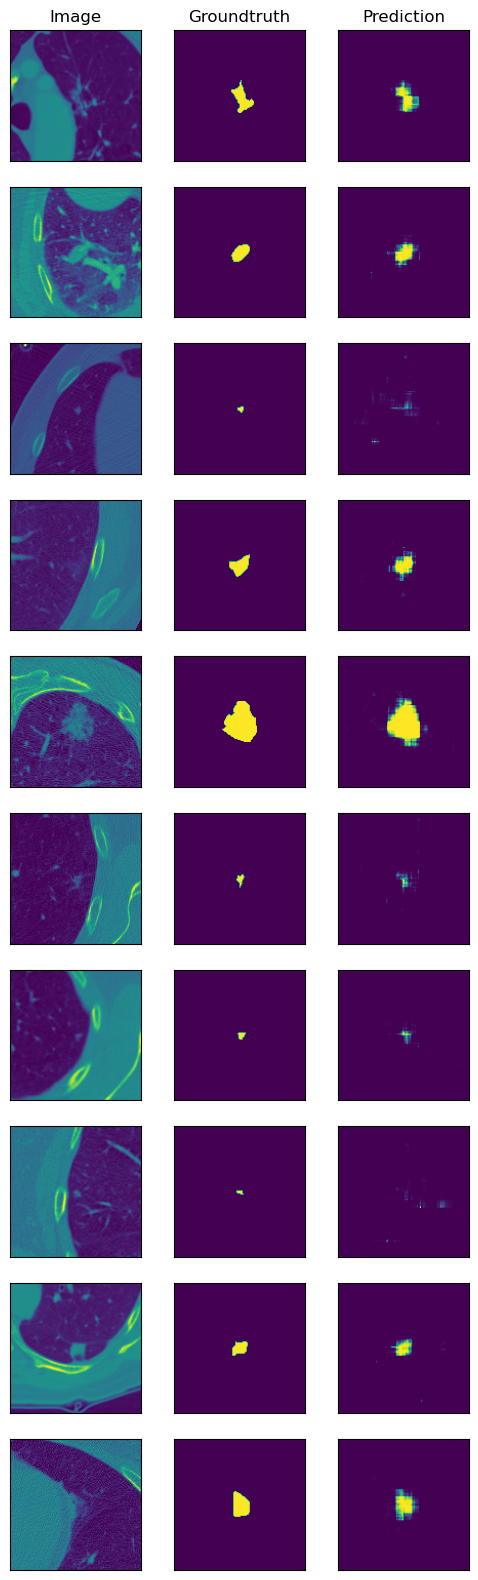

In [12]:
fig, axs = plt.subplots(10,3, figsize=(6,20))

for i in range(10):
    
    axs[i,0].imshow(train_images[i])
    axs[i,1].imshow(train_targets[i])
    axs[i,2].imshow(train_prediction[i,...,1])
    
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,2].set_xticks([])
    axs[i,2].set_yticks([])
    
axs[0,0].set_title('Image')
axs[0,1].set_title('Groundtruth')
axs[0,2].set_title('Prediction')
    
plt.show()

Lastly, let's examine the predictions of segments on the test images.

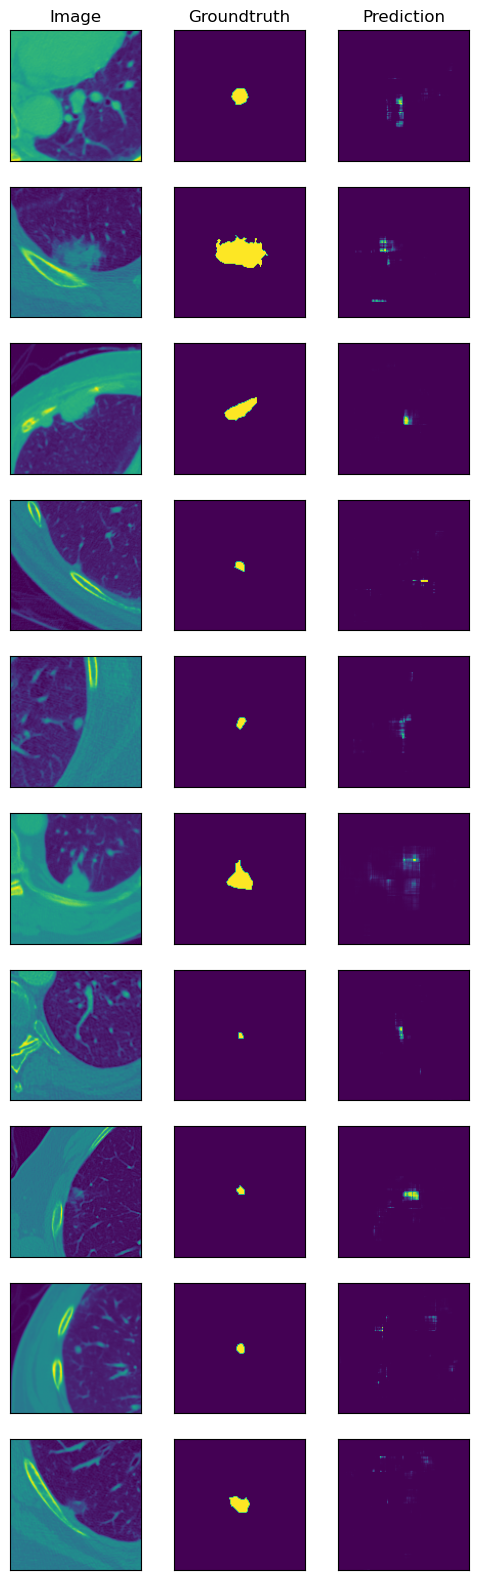

In [13]:
fig, axs = plt.subplots(10,3, figsize=(6,20))

for i in range(10):
    
    axs[i,0].imshow(test_images[i])
    axs[i,1].imshow(test_targets[i])
    axs[i,2].imshow(test_prediction[i,...,1])
    
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,2].set_xticks([])
    axs[i,2].set_yticks([])
    
axs[0,0].set_title('Image')
axs[0,1].set_title('Groundtruth')
axs[0,2].set_title('Prediction')
    
plt.show()